## Network Analysis of EBMUD Water Distribution System in NetworKit ##

Install Packages

In [1]:
import networkit as nk
import importlib.metadata

try:
    version = importlib.metadata.version('networkit')
    print(f"NetworKit version: {version}")
except importlib.metadata.PackageNotFoundError:
    print("NetworKit is not installed.")

NetworKit version: 10.1


In [2]:
from networkit import vizbridges
from networkit import graph
from networkit import graphio
from shapely.geometry import Point, LineString

In [3]:
%pip install contextily
import contextily as ctx
import pandas as pd 
import geopandas as gpd
%pip install matplotlib 
import matplotlib.pyplot as plt
import networkx as nx
%pip install seaborn
import seaborn as sns 
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Read in Data

In [ ]:
pipe_data = gpd.read_file('/home/veronica/data/pipeline_data.geojson')
num_features = len(pipe_data)
print(f"Number of features in the file: {num_features}")
pipe_data.head()

Number of features in the shapefile: 193875


,OBJECTID,ENABLED,FACILITYID,INSTALLDATE,STATUSCHANGEDATE,LIFECYCLESTATUS,WATERTYPE,MATERIALTYPE,MGE_MSLINK,LININGMATERIALTYPE,...,ORDERNUMBER,DISTANCETORW,VERTEXCOUNT,GEOGRAPHIC_FIDELITY,ISHIGHPRESSURE,ISRESTRAINEDJOINT,PRESPLIT_FACID,GLOBALID,SHAPE_Length,geometry
0,327273,1.0,19971,None,None,AC,Potable,A,1015809.0,U,...,None,None,8.0,Unknown,None,NaN,19971.0,{84FFB371-878D-4AC7-A0CC-1FD88A08B718},34.586882,"MULTILINESTRING ((-122.01900 37.81434, -122.01..."
1,327274,1.0,20383,None,None,AC,Potable,S,1015849.0,M,...,None,None,12.0,Unknown,None,NaN,20383.0,{BC267C5B-A5D8-49AF-A5CD-AE45B9F9ECED},5.085738,"MULTILINESTRING ((-122.02131 37.81735, -122.02..."
2,327275,1.0,20377,None,None,AC,Potable,S,1015840.0,U,...,None,None,3.0,Unknown,None,NaN,NaN,{5F8B7A3D-3B96-45B4-A87C-FC5E95614EDA},47.460385,"MULTILINESTRING ((-122.02007 37.81645, -122.01..."
3,327276,1.0,103022,None,None,AC,Potable,A,4061041.0,U,...,None,None,4.0,Unknown,None,NaN,103022.0,{A4E5F113-77D7-4A71-9591-070A5A48411F},4.558327,"MULTILINESTRING ((-122.01905 37.81440, -122.01..."
4,327277,1.0,100911,None,None,AC,Potable,S,4052734.0,M,...,None,None,2.0,Unknown,None,NaN,NaN,{AA23F5C1-7BA2-4D80-9A7C-B26995D9C222},14.561382,"MULTILINESTRING ((-122.02085 37.81623, -122.02..."


In [5]:
# List all columns of the DataFrame
print("Columns in the Water DataFrame:", pipe_data.columns.tolist())

Columns in the Water DataFrame: ['OBJECTID', 'ENABLED', 'FACILITYID', 'INSTALLDATE', 'STATUSCHANGEDATE', 'LIFECYCLESTATUS', 'WATERTYPE', 'MATERIALTYPE', 'MGE_MSLINK', 'LININGMATERIALTYPE', 'ROUGHNESS', 'ROUGHNESSUNITTYPE', 'COATINGMATERIALTYPE', 'STREETNAME', 'PIPEEXTENSIONNUMBER', 'NOMDIAMUNITTYPE', 'PRESSUREZONE', 'MAINTPRIORITYTYPE', 'INSTALLATIONYEAR', 'HASCULVERTENCASEMENT', 'CULVERTDIAMETER', 'CULVERTDIAMETERUNITTYPE', 'CPSYSTEMOBJECTID', 'CPSYSTEMSTATUS', 'MEASUREDLENGTH', 'OPERATINGPRESSURE', 'WATERTRACEWEIGHT', 'DRAWINGNUMBER', 'CREATIONUSER', 'DATECREATED', 'LASTUSER', 'DATEMODIFIED', 'BASEMAP', 'CITY', 'AQUEDUCT_NAME', 'REPAIR_NUMBER', 'NOMINALDIAMETER', 'RFS_NUMBER', 'OWNED_BY', 'SUBTYPE', 'CASINGTYPE', 'COMMENTS', 'ORDERNUMBER', 'DISTANCETORW', 'VERTEXCOUNT', 'GEOGRAPHIC_FIDELITY', 'ISHIGHPRESSURE', 'ISRESTRAINEDJOINT', 'PRESPLIT_FACID', 'GLOBALID', 'SHAPE_Length', 'geometry']


In [5]:
facilities_data = gpd.read_file('/home/veronica/data/facilities.geojson')
num_features = len(facilities_data)
print(f"Number of features in the file: {num_features}")
facilities_data.head()

Number of features in the file: 1372


,OBJECTID,FAC_GN,FAC_NM,FAC_ADDR_T,STRCT_NU,PRSZ_CD,PRSZ_DESC_,PRSZ_HILL_,PRSZ_SRC_C,PRSZ_SRC_D,...,FAC_TEMP_F,FAC_STBY_F,FAC_STAFFE,WTR_TYPE_C,FAC_ABBRV_,MAINT_AREA,FAC_NAD83_,FAC_NAD831,STRCT_NM,geometry
0,25,2736,SCHAPIRO RESERVOIR,WEST OF END OF BONITA RD.,2105.0,A2A,Berryman,W,None,None,...,N,N,N,P,SCHAPIRO NO. 2,1.0,6036910.0,2175744.0,Schapiro Reservoir,POINT (-122.32019 37.95621)
1,26,2762,MALCOLM REGULATOR,"3698 MALCOLM AVENUE, OAKLAND, CA",2115.0,B5D,Country Club,W,B3A,Piedmont,...,N,N,N,P,None,2.0,6087958.0,2098641.0,Malcolm No. 2 Regulator,POINT (-122.13848 37.74709)
2,27,2740,ROUND HILL NO. 2 PUMPING PLANT,"455 LIVORNA ROAD, ALAMO, CA",2107.0,F7D,Round Hill,E,F5B,Diablo,...,N,N,N,P,ROUND HILL NO. 2,1.0,6125211.0,2142624.0,Round Hill No. 2 Pumping Plant,POINT (-122.01211 37.86959)
3,28,2006,LELAND NO. 2 PUMPING PLANT,2201 Larkey Ave.,2103.0,H1A,Leland,E,H1A,Leland,...,N,N,N,P,LELAND NO. 2 PP,1.0,6104610.0,2159586.0,Leland No. 2 Pumping Plant,POINT (-122.08446 37.91523)
4,29,2813,ESTATES NO. 2 RESERVOIR,"6317 ESTATES DRIVE, OAKLAND, CA",2116.0,B5A,Dingee,W,None,None,...,N,N,N,P,None,2.0,6065892.0,2128229.0,Estates Reservoir (Proposed),POINT (-122.21666 37.82725)


Build Graph in NetworKit

In [6]:
# Create an empty undirected graph in NetworKit 
G_nk = nk.Graph(n=0, weighted=False, directed=False)

# Verify the graph is created
print("Number of nodes:", G_nk.numberOfNodes())
print("Number of edges:", G_nk.numberOfEdges())

Number of nodes: 0
Number of edges: 0


In [7]:
# Create a mapping from coordinates to unique integer node identifiers
coord_to_node = {}
node_counter = 0

In [8]:
# Use a set to track edges to avoid duplicates
added_edges = set()

# Iterate through the pipe features
for idx, row in pipe_data.iterrows():
    geometry = row.geometry
    
    if geometry.type == 'LineString':
        coords = list(geometry.coords)
    elif geometry.type == 'MultiLineString':
        coords = [coord for line in geometry.geoms for coord in line.coords]
    else:
        continue  # Skip unsupported geometry types

    # Add nodes and edges
    for i in range(len(coords) - 1):
        start_coord = coords[i]
        end_coord = coords[i + 1]

        # Map coordinates to unique node IDs
        if start_coord not in coord_to_node:
            coord_to_node[start_coord] = node_counter
            G_nk.addNode()
            node_counter += 1

        if end_coord not in coord_to_node:
            coord_to_node[end_coord] = node_counter
            G_nk.addNode()
            node_counter += 1

        start_node = coord_to_node[start_coord]
        end_node = coord_to_node[end_coord]

        # Add edge only if it doesn't already exist
        edge = (start_node, end_node)
        if edge not in added_edges and (end_node, start_node) not in added_edges:
            G_nk.addEdge(start_node, end_node)
            added_edges.add(edge)

# Verify the graph
print("Total Number of Nodes:", G_nk.numberOfNodes())
print("Total Number of Edges:", G_nk.numberOfEdges())

/tmp/ipykernel_3426913/1504050709.py:8: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'LineString':
/tmp/ipykernel_3426913/1504050709.py:10: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'MultiLineString':


Total Number of Nodes: 1372418
Total Number of Edges: 1384839


In [9]:
# Create a DataFrame from the node list
node_list = [{'Node ID': node_id, 'Longitude': coord[0], 'Latitude': coord[1]} for coord, node_id in coord_to_node.items()]

# Convert the list to a DataFrame
df_nodes = pd.DataFrame(node_list)

# Save the DataFrame to a CSV file
df_nodes.to_csv('/home/veronica/data/node_list.csv', index=False)

# Print the DataFrame to verify
print(df_nodes)

         Node ID   Longitude   Latitude
0              0 -122.019001  37.814343
1              1 -122.018985  37.814324
2              2 -122.018964  37.814301
3              3 -122.018938  37.814276
4              4 -122.018928  37.814268
...          ...         ...        ...
1372413  1372413 -122.281992  37.887285
1372414  1372414 -122.247702  37.796177
1372415  1372415 -122.239574  37.788060
1372416  1372416 -122.330922  37.954857
1372417  1372417 -122.240404  37.788673

[1372418 rows x 3 columns]


In [10]:
# Create a DataFrame from the edge list
edge_list = [{'Source': edge[0], 'Target': edge[1], 'Weight': G_nk.weight(edge[0], edge[1])} for edge in G_nk.iterEdges()]

# Convert the list to a DataFrame
df_edges = pd.DataFrame(edge_list)

# Save the DataFrame to a CSV file
df_edges.to_csv('/home/veronica/data/edge_list.csv', index=False)

# Print the DataFrame to verify
print(df_edges)

          Source   Target  Weight
0              0        1     1.0
1              0      371     1.0
2              1        2     1.0
3              2        3     1.0
4              3        4     1.0
...          ...      ...     ...
1384834  1372408  1372409     1.0
1384835  1372409  1372410     1.0
1384836  1372410  1372411     1.0
1384837  1372411  1372412     1.0
1384838  1372412  1372413     1.0

[1384839 rows x 3 columns]


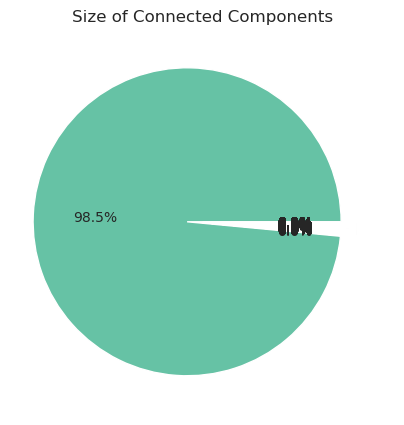

In [12]:
# Plot connected components sizes of the network 
nk.plot.connectedComponentsSizes(G_nk, relativeSizes=True)

In [13]:
# Extract the largest connected component of the graph
# Step 1: Find connected components
cc = nk.components.ConnectedComponents(G_nk)
cc.run()
components = cc.getComponents()

# Step 2: Sort the connected components by size in descending order
components_sorted = sorted(components, key=len, reverse=True)

# Step 3: Check if there are any connected components
if components_sorted:
    # Create a subgraph for analysis using the largest connected component
    largest_component = components_sorted[0]
    G_sub = nk.graphtools.subgraphFromNodes(G_nk, largest_component)
    print("Subgraph created with", G_sub.numberOfNodes(), "nodes and", G_sub.numberOfEdges(), "edges.")
else:
    print("No connected components found in the graph.")


Subgraph created with 1351853 nodes and 1364767 edges.


## Compute Network Metrics ##

In [14]:
# Profiling overall picture of the network
import warnings
warnings.filterwarnings('ignore')
nk.profiling.Profile.create(G_nk).show()

Network Structural Profile 
 
	<!--- HELP --->
 Navigating the profile 
 
 the profile includes the following sections by default: 
 
 global properties 
 overview of node centrality and partition distributions 
 detail views of node centrality distributions 
 node centrality correlations 
 detail views of partitions 
 
 click [+] for descriptions of measures 
 click on distribution thumbnail for detail view 
 hover over variable name of statistical figures for explanation 
 click on distribution plot for larger view 
 
 
	<!--- END HELP --->
 
 1372418 
 1384839 
 1.47047e-06 
 False 
 False 
 0 
 (10498, 10498) 
 N/A 
 516 
 
 
 
 <img src="data:image/svg+xml;utf8,%3Csvg%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20width%3D%22288pt%22%20height%3D%22180pt%22%20viewBox%3D%220%200%20288%20180%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20version%3D%221.1%22%3E%20%3Cmetadata%3E%20%3Crdf%3ARDF%20xmlns%3Adc%3D%22http%3A%2F%2Fpurl.org%2Fdc%2Felements%2F1.1%2F%22%20xmlns%3Acc%3D%22http%3A%2F%2Fcreativecommons.org%2Fns%23%22%20xmlns%3Ardf%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2F02%2F22-rdf-syntax-ns%23%22%3E%20%3Ccc%3AWork%3E%20%3Cdc%3Atype%20rdf%3Aresource%3D%22http%3A%2F%2Fpurl.org%2Fdc%2Fdcmitype%2FStillImage%22%2F%3E%20%3Cdc%3Adate%3E2025-04-17T19%3A52%3A22.198608%3C%2Fdc%3Adate%3E%20%3Cdc%3Aformat%3Eimage%2Fsvg%2Bxml%3C%2Fdc%3Aformat%3E%20%3Cdc%3Acreator%3E%20%3Ccc%3AAgent%3E%20%3Cdc%3Atitle%3EMatplotlib%20v3.8.4%2C%20https%3A%2F%2Fmatplotlib.org%2F%3C%2Fdc%3Atitle%3E%20%3C%2Fcc%3AAgent%3E%20%3C%2Fdc%3Acreator%3E%20%3C%2Fcc%3AWork%3E%20%3C%2Frdf%3ARDF%3E%20%3C%2Fmetadata%3E%20%3Cdefs%3E%20%3Cstyle%20type%3D%22text%2Fcss%22%3E%2A%7Bstroke-linejoin%3A%20round%3B%20stroke-linecap%3A%20butt%7D%3C%2Fstyle%3E%20%3C%2Fdefs%3E%20%3Cg%20id%3D%22figure_1%22%3E%20%3Cg%20id%3D%22patch_1%22%3E%20%3Cpath%20d%3D%22M%200%20180%20L%20288%20180%20L%20288%200%20L%200%200%20z%20%22%20style%3D%22fill%3A%20%23ffffff%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22axes_1%22%3E%20%3Cg%20id%3D%22patch_2%22%3E%20%3Cpath%20d%3D%22M%2040.12%20138.04%20L%20263.12%20138.04%20L%20263.12%2021.72%20L%2040.12%2021.72%20z%20%22%20style%3D%22fill%3A%20%23ffffff%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22matplotlib.axis_1%22%3E%20%3Cg%20id%3D%22xtick_1%22%3E%20%3Cg%20id%3D%22line2d_1%22%3E%20%3Cpath%20d%3D%22M%2048.379259%20138.04%20L%2048.379259%2021.72%20%22%20clip-path%3D%22url%28%23p7d01f729e5%29%22%20style%3D%22fill%3A%20none%3B%20stroke%3A%20%23d3d3d3%3B%20stroke-width%3A%200.8%3B%20stroke-linecap%3A%20round%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_1%22%3E%20%3C%21--%20%24%5Cmathdefault%7B1%7D%24%20--%3E%20%3Cg%20transform%3D%22translate%2845.179259%20152.638438%29%20scale%280.1%20-0.1%29%22%3E%20%3Cdefs%3E%20%3Cpath%20id%3D%22DejaVuSans-31%22%20d%3D%22M%20794%20531%20L%201825%20531%20L%201825%204091%20L%20703%203866%20L%20703%204441%20L%201819%204666%20L%202450%204666%20L%202450%20531%20L%203481%20531%20L%203481%200%20L%20794%200%20L%20794%20531%20z%20%22%20transform%3D%22scale%280.015625%29%22%2F%3E%20%3C%2Fdefs%3E%20%3Cuse%20xlink%3Ahref%3D%22%23DejaVuSans-31%22%20transform%3D%22translate%280%200.09375%29%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22xtick_2%22%3E%20%3Cg%20id%3D%22line2d_2%22%3E%20%3Cpath%20d%3D%22M%2089.675556%20138.04%20L%2089.675556%2021.72%20%22%20clip-path%3D%22url%28%23p7d01f729e5%29%22%20style%3D%22fill%3A%20none%3B%20stroke%3A%20%23d3d3d3%3B%20stroke-width%3A%200.8%3B%20stroke-linecap%3A%20round%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_2%22%3E%20%3C%21--%20%24%5Cmathdefault%7B2%7D%24%20--%3E%20%3Cg%20transform%3D%22translate%2886.475556%20152.638438%29%20scale%280.1%20-0.1%29%22%3E%20%3Cdefs%3E%20%3Cpath%20id%3D%22DejaVuSans-32%22%20d%3D%22M%201228%20531%20L%203431%20531%20L%203431%200%20L%20469%200%20L%20469%20531%20Q%20828%20903%201448%201529%20Q%202069%202156%202228%202338%20Q%202531%202678%202651%202914%20Q%202772%203150%202772%203378%20Q%202772%203750%202511%203984%20Q%202250%204219%20

Degree Distribution

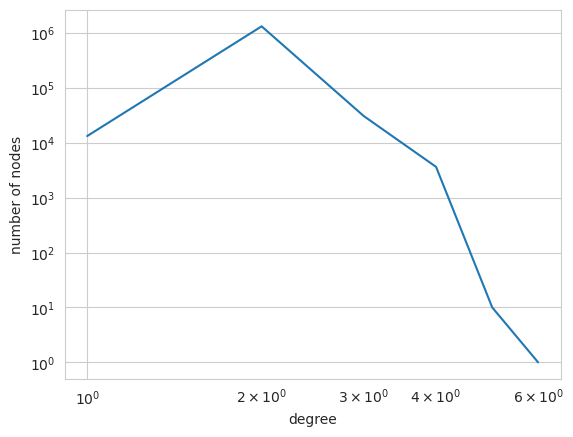

In [15]:
# Plot Degree Distribution of the EBMUD Water Network
dd = sorted(nk.centrality.DegreeCentrality(G_nk).run().scores(), reverse=True)
degrees, numberOfNodes = np.unique(dd, return_counts=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(degrees, numberOfNodes)
plt.show()

Average Degree

In [19]:
print("Average degree of EBMUD Water Network = ",2*G_nk.numberOfEdges()/G_nk.numberOfNodes())
print("Average degree of EBMUD Water Subnetwork = ",2*G_sub.numberOfEdges()/G_sub.numberOfNodes())

Average degree of EBMUD Water Network =  2.018100899288701
Average degree of EBMUD Water Subnetwork =  2.019105627608919


Average Clustering Coefficient

In [20]:
# Calculate the average clustering coefficient for the entire network
clustering_coefficient = nk.centrality.LocalClusteringCoefficient(G_nk)
clustering_coefficient.run()
average_clustering_coefficient = sum(clustering_coefficient.scores()) / G_nk.numberOfNodes()
print("Average Clustering Coefficient of EBMUD Water Network =", average_clustering_coefficient)

Average Clustering Coefficient of EBMUD Water Network = 7.0435294980586575e-06


In [21]:
# Calculate the average clustering coefficient for the sub network
clustering_coefficient = nk.centrality.LocalClusteringCoefficient(G_sub)
clustering_coefficient.run()
average_clustering_coefficient = sum(clustering_coefficient.scores()) / G_sub.numberOfNodes()
print("Average Clustering Coefficient of EBMUD Water Sub Network =", average_clustering_coefficient)

Average Clustering Coefficient of EBMUD Water Sub Network = 7.150678858327544e-06


## Centrality ##

Degree Centrality

In [ ]:
# Initialize algorithm
deg = nk.centrality.DegreeCentrality(G_nk)
deg.run()
deg_centrality = deg.scores() 

In [ ]:
# Add degree centrality scores to the Node List DataFrame
df_nodes['Degree Centrality'] = df_nodes['Node ID'].map(lambda node: deg_centrality[node])

# Save the DataFrame to a CSV file
df_nodes.to_csv('/home/veronica/data/node_list_dc.csv', index=False)

# Print the DataFrame to verify
print(df_nodes.head())

   Node ID   Longitude   Latitude  Degree Centrality
0        0 -122.019001  37.814343                2.0
1        1 -122.018985  37.814324                2.0
2        2 -122.018964  37.814301                2.0
3        3 -122.018938  37.814276                2.0
4        4 -122.018928  37.814268                2.0


In [ ]:
# 10 most central nodes according to degree centrality are
central_nodes_deg = deg.ranking()[:10]

# Convert the list to a Most Central Nodes DataFrame
df_central_nodes_dc = pd.DataFrame(central_nodes_deg, columns=['Node ID', 'Degree Centrality'])

# Merge the central nodes DataFrame with the node list DataFrame to add coordinates
df_central_nodes_dc = df_central_nodes_dc.merge(df_nodes[['Node ID', 'Longitude', 'Latitude']], on='Node ID')

# Save the DataFrame to a CSV file
df_central_nodes_dc.to_csv('/home/veronica/output/central_nodes_dc.csv', index=False)

print("Most central nodes in EBMUD Subnetwork according to Degree Centrality:")
df_central_nodes_dc

Most central nodes in EBMUD Subnetwork according to Degree Centrality:


,Node ID,Degree Centrality,Longitude,Latitude
0,851915,8.0,-122.158015,37.890304
1,55889,5.0,-122.087191,37.927644
2,81306,5.0,-122.231462,37.842692
3,105501,5.0,-122.243725,37.823159
4,285892,5.0,-122.136554,37.670011
5,429496,5.0,-122.189649,37.760347
6,433298,5.0,-122.189665,37.760354
7,486669,5.0,-122.313068,37.941971
8,582916,5.0,-122.350188,37.951758
9,644563,5.0,-122.306260,37.938046


Betweenness Centrality

In [ ]:
# Initalize algorithm
btwn = nk.centrality.Betweenness(G_sub)

In [ ]:
# Run 
btwn.run()

In [ ]:
btwn_centrality = btwn.scores() 

In [ ]:
# Add betweenness centrality scores to the Node List DataFrame
df_nodes['Betweenness Centrality'] = df_nodes['Node ID'].map(lambda node: btwn_centrality[node])

# Save the DataFrame to a CSV file
df_nodes.to_csv('/home/veronica/data/node_list_dc_btwn.csv', index=False)

# Print the DataFrame to verify
print(df_nodes.head())

   Node ID   Longitude   Latitude  Degree Centrality  Betweenness Centrality
0        0 -122.019001  37.814343                2.0             256833830.0
1        1 -122.018985  37.814324                2.0             254130504.0
2        2 -122.018964  37.814301                2.0             251427174.0
3        3 -122.018938  37.814276                2.0             248723840.0
4        4 -122.018928  37.814268                2.0             246020502.0


In [ ]:
# 10 most central nodes according to betweenness centrality are
central_nodes_btwn = btwn.ranking()[:10]

# Convert the list to a Most Central Nodes DataFrame
df_central_nodes_btwn = pd.DataFrame(central_nodes_btwn, columns=['Node ID', 'Betweenness Centrality'])

# Merge the central nodes DataFrame with the node list DataFrame to add coordinates
df_central_nodes_btwn = df_central_nodes_btwn.merge(df_nodes[['Node ID', 'Longitude', 'Latitude']], on='Node ID')

# Save the DataFrame to a CSV file
df_central_nodes_btwn.to_csv('/home/veronica/output/central_nodes_btwn.csv', index=False)

print("Most central nodes in EBMUD Subnetwork according to Betweenness Centrality:")
df_central_nodes_btwn

Most central nodes in EBMUD Subnetwork according to Betweenness Centrality:


,Node ID,Betweenness Centrality,Longitude,Latitude
0,328482,8.419953e+11,-122.147781,37.727160
1,304640,8.406737e+11,-122.147832,37.727275
2,324413,8.397080e+11,-122.150915,37.733582
3,282941,8.396103e+11,-122.149362,37.730777
4,303066,8.394844e+11,-122.149670,37.731488
5,276211,8.392208e+11,-122.149081,37.730090
6,365381,8.391995e+11,-122.148792,37.729474
7,276212,8.391949e+11,-122.149077,37.730087
8,276213,8.391946e+11,-122.149065,37.730080
9,276214,8.391943e+11,-122.149056,37.730069
